In [13]:
import numpy as np
import struct

# Function to load MNIST images
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return data.reshape(num, rows, cols).astype(np.float32) / 255.0

# Function to load MNIST labels
def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return data

# Load the datasets
train_images = load_mnist_images('train-images.idx3-ubyte')
train_labels = load_mnist_labels('train-labels.idx1-ubyte')
test_images = load_mnist_images('t10k-images.idx3-ubyte')
test_labels = load_mnist_labels('t10k-labels.idx1-ubyte')

# Preprocess for FFNN (flatten images)
train_images_flat = train_images.reshape(train_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

# Preprocess for CNN (reshape images)
train_images_cnn = train_images.reshape(-1, 28, 28, 1)
test_images_cnn = test_images.reshape(-1, 28, 28, 1)

print("Train images shape (flat):", train_images_flat.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape (flat):", test_images_flat.shape)
print("Test labels shape:", test_labels.shape)


Train images shape (flat): (60000, 784)
Train labels shape: (60000,)
Test images shape (flat): (10000, 784)
Test labels shape: (10000,)


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.metrics import confusion_matrix
import numpy as np

# FFNN Model Definition
def create_ffnn(input_shape):
    return Sequential([
        Input(shape=input_shape),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])

# Function to evaluate FFNN for 5 runs and return predictions for the first run
def evaluate_ffnn_with_predictions(train_data, train_labels, test_data, test_labels):
    accuracies = []
    history_ffnn = None
    predicted_labels_ffnn = None
    for run in range(5):
        print(f"FFNN Run {run + 1}/5")
        model = create_ffnn((784,))
        model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(train_data, train_labels, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
        if run == 0:  # Store the history and predictions for the first run
            history_ffnn = history
            predictions = model.predict(test_data, verbose=0)
            predicted_labels_ffnn = np.argmax(predictions, axis=1)
        _, test_accuracy = model.evaluate(test_data, test_labels, verbose=0)
        accuracies.append(test_accuracy)
        print(f"Run {run + 1} Test Accuracy: {test_accuracy:.4f}")
    avg_accuracy = np.mean(accuracies)
    print(f"\nFFNN Average Test Accuracy: {avg_accuracy:.4f}")
    return accuracies, avg_accuracy, history_ffnn, predicted_labels_ffnn

# Evaluate FFNN and capture predictions
ffnn_accuracies, ffnn_avg_accuracy, history_ffnn, predicted_labels_ffnn = evaluate_ffnn_with_predictions(
    train_images_flat, train_labels, test_images_flat, test_labels
)

# Calculate FFNN confusion matrix
conf_matrix_ffnn = confusion_matrix(test_labels, predicted_labels_ffnn)


FFNN Run 1/5
Run 1 Test Accuracy: 0.9787
FFNN Run 2/5
Run 2 Test Accuracy: 0.9740
FFNN Run 3/5
Run 3 Test Accuracy: 0.9770
FFNN Run 4/5
Run 4 Test Accuracy: 0.9743
FFNN Run 5/5
Run 5 Test Accuracy: 0.9732

FFNN Average Test Accuracy: 0.9754


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from sklearn.metrics import confusion_matrix
import numpy as np

# CNN Model Definition
def create_cnn(input_shape):
    return Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])

# Function to evaluate CNN for 5 runs and return predictions for the first run
def evaluate_cnn_with_predictions(train_data, train_labels, test_data, test_labels):
    accuracies = []
    history_cnn = None
    predicted_labels_cnn = None
    for run in range(5):
        print(f"CNN Run {run + 1}/5")
        model = create_cnn((28, 28, 1))
        model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(train_data, train_labels, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
        if run == 0:  # Store the history and predictions for the first run
            history_cnn = history
            predictions = model.predict(test_data, verbose=0)
            predicted_labels_cnn = np.argmax(predictions, axis=1)
        _, test_accuracy = model.evaluate(test_data, test_labels, verbose=0)
        accuracies.append(test_accuracy)
        print(f"Run {run + 1} Test Accuracy: {test_accuracy:.4f}")
    avg_accuracy = np.mean(accuracies)
    print(f"\nCNN Average Test Accuracy: {avg_accuracy:.4f}")
    return accuracies, avg_accuracy, history_cnn, predicted_labels_cnn

# Evaluate CNN and capture predictions
cnn_accuracies, cnn_avg_accuracy, history_cnn, predicted_labels_cnn = evaluate_cnn_with_predictions(
    train_images_cnn, train_labels, test_images_cnn, test_labels)

# Calculate CNN confusion matrix
conf_matrix_cnn = confusion_matrix(test_labels, predicted_labels_cnn)


CNN Run 1/5
Run 1 Test Accuracy: 0.9907
CNN Run 2/5
Run 2 Test Accuracy: 0.9919
CNN Run 3/5
Run 3 Test Accuracy: 0.9911
CNN Run 4/5
Run 4 Test Accuracy: 0.9910
CNN Run 5/5
Run 5 Test Accuracy: 0.9928

CNN Average Test Accuracy: 0.9915


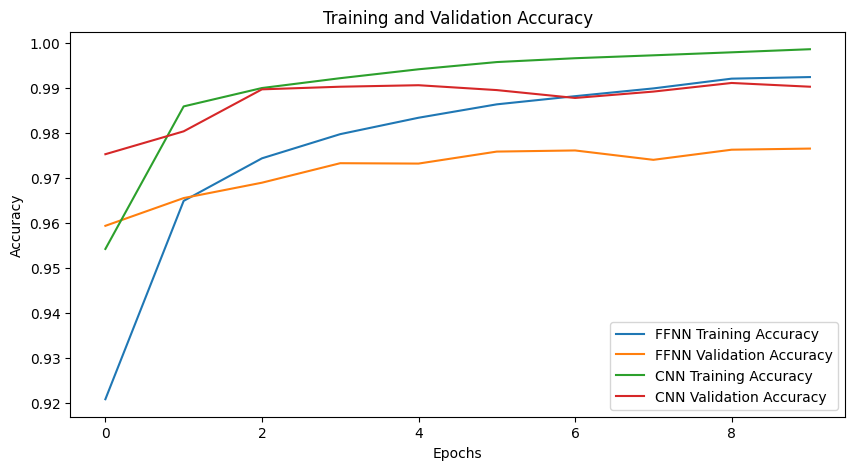

In [15]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy for FFNN and CNN

plt.figure(figsize=(10, 5))
plt.plot(history_ffnn.history['accuracy'], label='FFNN Training Accuracy')
plt.plot(history_ffnn.history['val_accuracy'], label='FFNN Validation Accuracy')
plt.plot(history_cnn.history['accuracy'], label='CNN Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='CNN Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


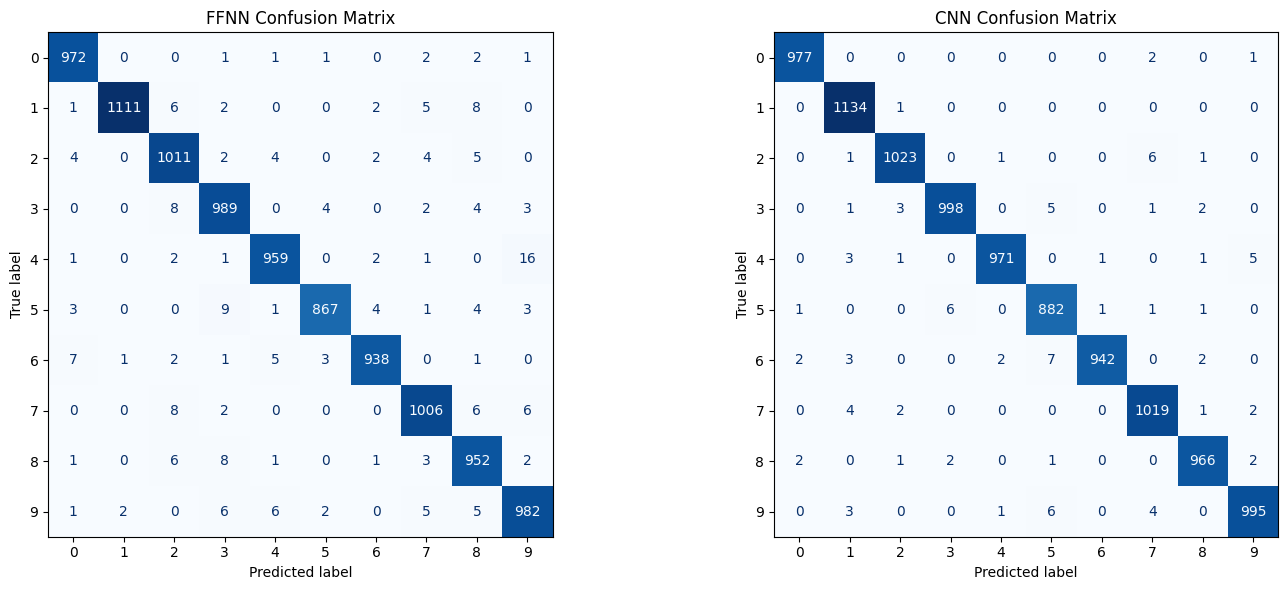

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Plot FFNN and CNN Confusion Matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Create 1 row, 2 columns

# FFNN Confusion Matrix
disp_ffnn = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_ffnn, display_labels=range(10))
disp_ffnn.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('FFNN Confusion Matrix')

# CNN Confusion Matrix
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_cnn, display_labels=range(10))
disp_cnn.plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title('CNN Confusion Matrix')

# Adjust layout
plt.tight_layout()
plt.show()

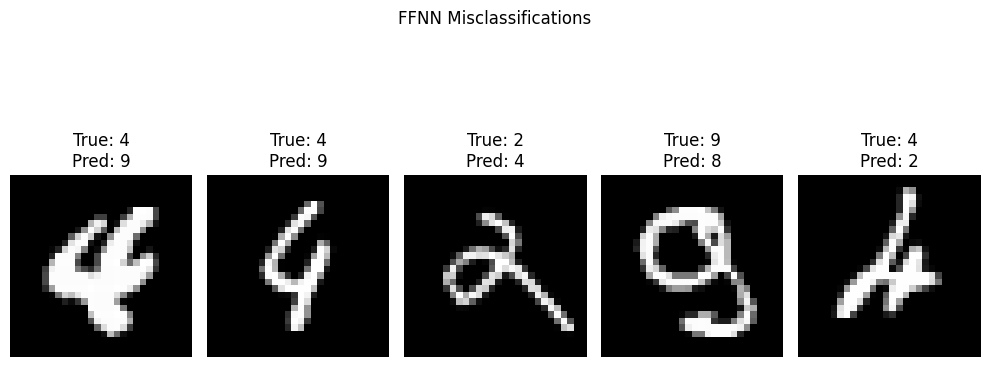

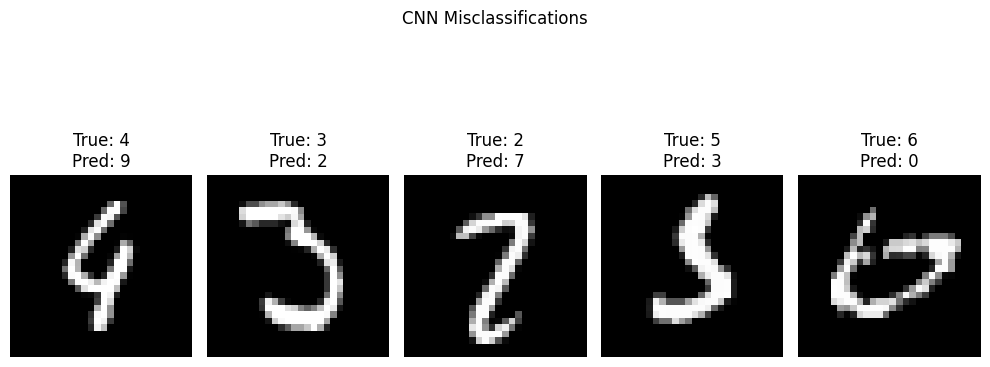

In [17]:
# FFNN Misclassifications
misclassified_indices_ffnn = np.where(predicted_labels_ffnn != test_labels)[0]

plt.figure(figsize=(10, 5))
for i, idx in enumerate(misclassified_indices_ffnn[:5]):  # Show 5 misclassified images
    plt.subplot(1, 5, i + 1)
    plt.imshow(test_images[idx].reshape(28, 28), cmap='gray')
    plt.title(f"True: {test_labels[idx]}\nPred: {predicted_labels_ffnn[idx]}")
    plt.axis('off')
plt.suptitle("FFNN Misclassifications")
plt.tight_layout()
plt.show()

# CNN Misclassifications
misclassified_indices_cnn = np.where(predicted_labels_cnn != test_labels)[0]

plt.figure(figsize=(10, 5))
for i, idx in enumerate(misclassified_indices_cnn[:5]):  # Show 5 misclassified images
    plt.subplot(1, 5, i + 1)
    plt.imshow(test_images[idx].reshape(28, 28), cmap='gray')
    plt.title(f"True: {test_labels[idx]}\nPred: {predicted_labels_cnn[idx]}")
    plt.axis('off')
plt.suptitle("CNN Misclassifications")
plt.tight_layout()
plt.show()
